### Business goal
1. Investigate the performance of ecommerce website with predefined metrics
2. Cluster users in terms of user activity and browsing behavior

### Performance Metrics
1. daily sale amount
2. daily user count 
3. distribution of user event and conversion rate
    * Monthly conversion rate = $\frac{\text{number of the users that purchase per month}}{\text{total users per month}}$
4. retention rate
    * Weekly retention rate = $\frac{\text{number of the users online in a given week are still online in the following week}}{\text{total users in the given week}}$

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import seaborn as sns

%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Nov.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Feb.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Oct.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Dec.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Jan.csv


In [2]:
# oct data as example
df = pd.read_csv("/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Oct.csv")
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4102283 entries, 0 to 4102282
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 281.7+ MB


The presence of each user in this month:

In [4]:
# event counts of each consumer
df['user_id'].value_counts()

510369366    3965
550388516    3087
516768752    2330
494539592    2280
541975884    2159
             ... 
562901529       1
558873160       1
558797421       1
432966254       1
566239228       1
Name: user_id, Length: 399664, dtype: int64

In [5]:
df.isnull().mean()

event_time       0.000000
event_type       0.000000
product_id       0.000000
category_id      0.000000
category_code    0.983551
brand            0.404473
price            0.000000
user_id          0.000000
user_session     0.000155
dtype: float64

### Preprocessing
1. Get the date, time point, and week number of the given month

In [6]:
# Format date, week and time column
df['date'] = df['event_time'].apply(lambda r: datetime.strptime(str(r)[:10], '%Y-%m-%d'))
df['timepoint'] = df['event_time'].apply(lambda r: datetime.strptime(str(r)[11:19], '%H:%M:%S').time())
df['week'] = df['date'].apply(lambda d: (d.day-1) // 7 + 1)

2. Drop rows with price < 0

In [7]:
df.drop(df[df.price < 0].index, inplace=True)

3. Drop duplicate records

In [8]:
df.drop_duplicates(inplace = True)

In [9]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,date,timepoint,week
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01,00:00:00,1
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01,00:00:03,1
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01,00:00:07,1
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01,00:00:07,1
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01,00:00:15,1


#### Metric 1: Daily sale amount

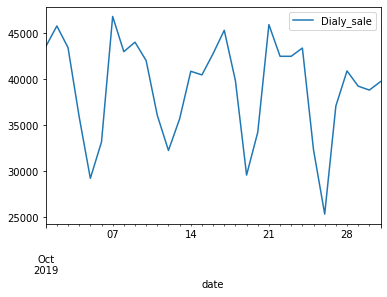

In [10]:
user_cnt_ax = df[df.event_type == "purchase"].groupby(['date'])['price'].agg(Dialy_sale = ('sum')).sort_values(by=['date'], ascending=True).plot.line()
user_cnt_ax.set_ylabel = "sale amount"

#### Metric 2: Daily user count

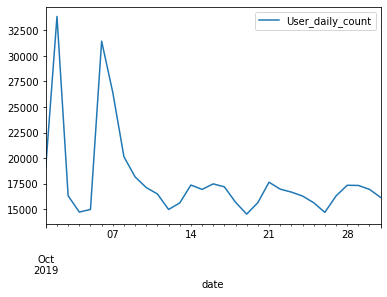

In [11]:
user_cnt_ax = df.groupby(['date'])['user_id'].agg(User_daily_count =('nunique')).sort_values(by=['date'], ascending=True).plot.line()
user_cnt_ax.set_ylabel = "user count"

#### Metric 3: Distribution of view, cart, purchase event and conversion rate (daily and monthly)

([<matplotlib.patches.Wedge at 0x7f9f4504b310>,
 [Text(0.07325650316422501, 1.0975579641841928, 'view'),
  Text(-0.7346463108274925, -0.8187153339150034, 'cart'),
  Text(0.7153408362219225, -0.8356359781826779, 'remove_from_cart'),
  Text(1.0784821734470187, -0.2165091258053456, 'purchase')],
 [Text(0.03995809263503182, 0.5986679804641052, '47.88%'),
  Text(-0.40071616954226863, -0.4465720003172745, '30.96%'),
  Text(0.3901859106665031, -0.455801442645097, '14.85%'),
  Text(0.5882630036983738, -0.11809588680291576, '6.31%')])

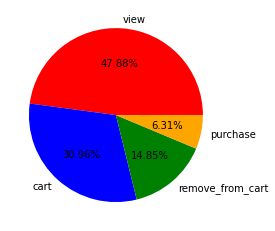

In [12]:
labels = ['view', 'cart', 'remove_from_cart','purchase']
colors = ['red', 'blue','green', 'orange']
plt.pie(df['event_type'].value_counts(), labels = labels, colors = colors, autopct = '%.2f%%')

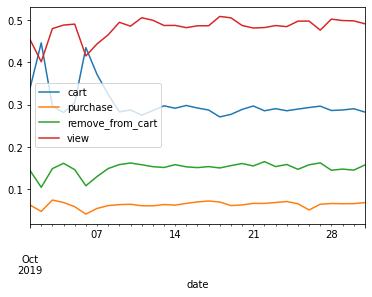

In [13]:
# daily conversion rate
event_type_ax = df.groupby(['date'])['event_type'].value_counts(['event_type']).unstack(level = -1).plot.line()
event_type_ax.legend(loc='best')

In [14]:
# monthly covnersion rate
len(df[df['event_type'] == "purchase"]['user_id'].unique())/len(df.user_id.unique())

0.0644591456823732

#### Weekly User Retention in this month
* What's proportion of the users online in a given week are still online in the following week.

Text(0.5, 1.0, 'October weekly retention rate ')

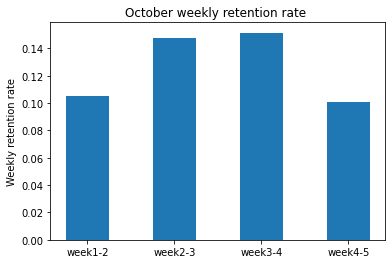

In [15]:
week_user_list = df.groupby(['week'])['user_id'].unique().to_list()
retention_list = [len(list(set(i)&set(j)))/len(list(i)) for i, j in zip(week_user_list[:5], week_user_list[1:])]
plt.bar(np.arange(4), retention_list, width = 0.5)
plt.ylabel("Weekly retention rate")
plt.xticks(np.arange(4), ["week1-2", "week2-3", "week3-4", "week4-5"])
plt.title("October weekly retention rate ")

### User segmentation 
This is the user clustering based on two dimensions of metrics, how active a user is at daily, month and purchase level and to what extend a user contribute to the monthly sale. In the first dimension, 391055 records were involved, no 0 values were removed because the majority of users have at least 1 day active or one session active per day. However, in the second and third dimension, most of users have 0 on all of the behavior related features and NAN in rate related features. Therefore these users records were removed and classified as a "inactive users"

1. user active dimension
    * Monthly active = how many days online per month
    * Daily active = number of sessions per day
    * Purcase price = total amount of transaction of each user



2. revenue dimension at event frequency level
    * Monthly purchase
    * Monthly price
    * Monthly view

3. revenue dimension at rate level
    * Monthly purchase/view rate 
    * Monthly purchase/cart rate
    * Monthly price/purchase rate

#### User active dimension

<AxesSubplot:>

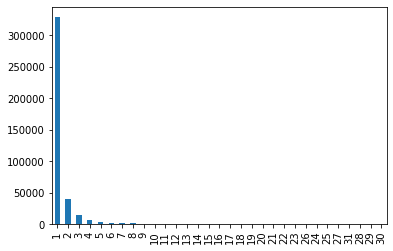

In [16]:
# number of days each participant show up in the given month
id_daycount = df.groupby(['user_id'])['date'].agg(montly_online_daycnt =('nunique')).sort_values(by=['montly_online_daycnt'])
id_daycount['montly_online_daycnt'].value_counts().plot(kind='bar')

In [17]:
# event number of each participant
id_sessioncount = df.groupby(['user_id'])['user_session'].agg(monthly_sessioncnt = ('nunique')).sort_values(by=['monthly_sessioncnt'])
id_sessioncount['monthly_sessioncnt'].value_counts(bins=20)

(-1.3479999999999999, 67.35]    399119
(67.35, 134.7]                     384
(134.7, 202.05]                     93
(202.05, 269.4]                     33
(269.4, 336.75]                     13
(336.75, 404.1]                      8
(404.1, 471.45]                      3
(673.5, 740.85]                      2
(471.45, 538.8]                      2
(538.8, 606.15]                      1
(606.15, 673.5]                      1
(740.85, 808.2]                      1
(942.9, 1010.25]                     1
(1010.25, 1077.6]                    1
(1212.3, 1279.65]                    1
(1279.65, 1347.0]                    1
(808.2, 875.55]                      0
(875.55, 942.9]                      0
(1077.6, 1144.95]                    0
(1144.95, 1212.3]                    0
Name: monthly_sessioncnt, dtype: int64

<AxesSubplot:>

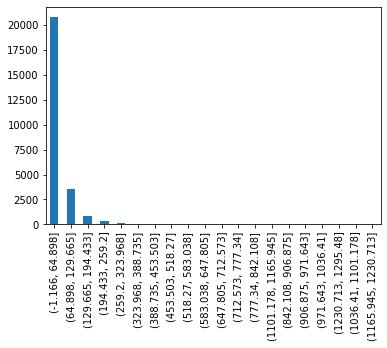

In [18]:
id_totalprice = df[df['event_type'].str.contains('purchase')].groupby(['user_id'])['price'].agg(monthly_totalprice = ('sum')).sort_values(by=['monthly_totalprice'])
id_totalprice['monthly_totalprice'].value_counts(bins=20).plot(kind='bar')

In [19]:
# concatenate three dataframe
activeuser_df = pd.concat([id_sessioncount, id_daycount, id_totalprice], axis=1)
activeuser_df['monthly_totalprice'].fillna(0, inplace = True)

#### Revenue dimension (freqeuncy and rate level)

In [20]:
behavior_df = df.groupby(['user_id', 'event_type']).size().unstack(fill_value=0)
price_df = df[df['event_type'].str.contains('purchase')].groupby(['user_id'])['price'].agg('sum')
behavior_df = behavior_df.merge(price_df, how = 'left', on = 'user_id')
behavior_df['price'].fillna(0, inplace = True)

In [21]:
# calculate the three rates
behavior_df['month_purchaseview_rate'] = behavior_df.purchase.div(behavior_df.view.replace(0, np.nan))
behavior_df['month_pricepurchase_rate'] = behavior_df.price.div(behavior_df.purchase.replace(0, np.nan))
behavior_df['month_purchasecart_rate'] = behavior_df.purchase.div(behavior_df.cart.replace(0, np.nan))

In [22]:
# drop nan rows based on the predefined three rates
behavior_df = behavior_df.dropna(subset=['month_purchaseview_rate', 'month_pricepurchase_rate', 'month_purchasecart_rate'])

In [23]:
# get the behavior feature at freq and rate level 
behavior_rate_df = behavior_df[['month_purchaseview_rate', 'month_pricepurchase_rate', 'month_purchasecart_rate']]
behavior_freq_df = behavior_df[['purchase', 'view', 'price']]

Text(0.5, 1.0, 'Behavior frequency boxplot')

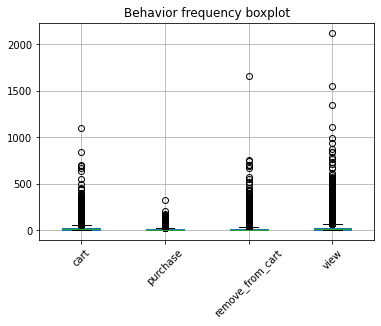

In [24]:
freq_boxplot = behavior_df.boxplot(rot=45, fontsize=10, column = ['cart', 'purchase', 'remove_from_cart', 'view'])
freq_boxplot.set_title('Behavior frequency boxplot')

Text(0.5, 1.0, 'Behavior rate boxplot')

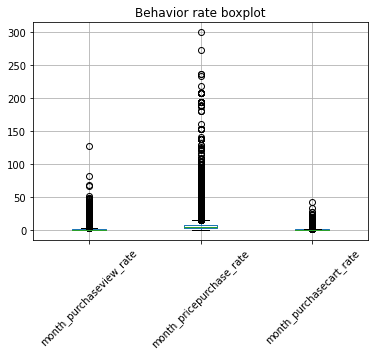

In [25]:
rate_boxplot = behavior_df.boxplot(rot=45, fontsize=10, column = ['month_purchaseview_rate', 'month_pricepurchase_rate', 'month_purchasecart_rate'] )
rate_boxplot.set_title('Behavior rate boxplot')

#### Clustering using k-means

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [27]:
# standardize the data before finding the k optimal value
X_activeuser = StandardScaler().fit_transform(activeuser_df)
X_freq_behavior = StandardScaler().fit_transform(behavior_freq_df)
X_rate_behavior = StandardScaler().fit_transform(behavior_rate_df)

##### Find the best k value for three dataset

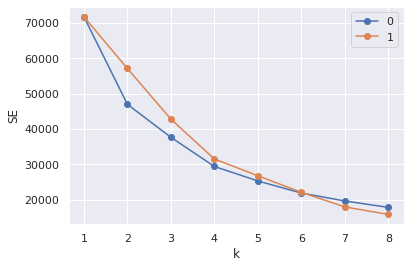

In [28]:
for j, XX in enumerate([X_freq_behavior, X_rate_behavior]): #X_freq_behavior, X_rate_behavior
    SSE=[]
    for i in range(1,9,1):
        kmeans=KMeans(n_clusters=i)
        kmeans.fit(XX)
        SSE.append(kmeans.inertia_)
    sns.set()
    plt.plot(range(1,9,1),SSE,marker='o', label = j)
plt.xlabel('k')
plt.ylabel('SE')
plt.legend()

In [29]:
import random
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
def k_mean_cluster(df, n_cluster, figsize = (6, 6)):
    '''
    Assign and visualize the cluster to given X
    :param: 
        df is dataframe
        n_cluster 
        


    ''' 
    # Check X validity
    assert len(df.columns) == 3, "Should be three features"
    X = df.copy()
    
    random.seed(7)
    km = KMeans(n_clusters=n_cluster, 
                init = "k-means++", 
                max_iter = 300, 
                n_init = 10, 
                random_state=0)
    X_standard = StandardScaler().fit_transform(X)
    km.fit(X_standard)
    y_pred = km.predict(X_standard)
    X['y_pred'] = list(y_pred)
    
    feat_columns = df.columns
    COLORS = sns.color_palette("tab10")[:n_cluster]
    
    
    # draw cluster mean statistics and scatter plot
    
    
    sns.countplot(x = 'y_pred', palette = COLORS, data = X)
#     sns.scatterplot(x=feat_columns[0],
#                     y=feat_columns[1],
#                     hue = 'y_pred',
#                     size=feat_columns[2],
#                     palette=mycolors,sizes=(200,1000), 
#                     legend=False,
#                     data=df_RFM3)

    fig = plt.figure(figsize = figsize)
    ax=Axes3D(fig)
    for k in range(n_cluster):
        # index of cluster k, correspinding feature value, 0, 1, 2
        ax.scatter(X.loc[X.y_pred == k, feat_columns[0]], 
                   X.loc[X.y_pred == k, feat_columns[1]],
                   X.loc[X.y_pred == k, feat_columns[2]], 
                   marker='o', alpha=0.5, color = COLORS[k], label = f"cluster {k}")
    
    ax.set_xlabel(feat_columns[0])
    ax.set_ylabel(feat_columns[1])
    ax.set_zlabel(feat_columns[2])
    ax.legend(loc='best')
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


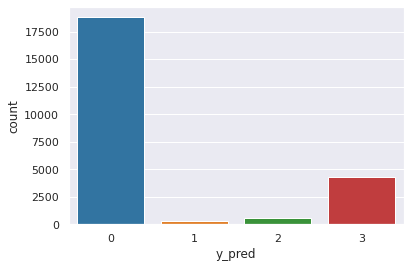

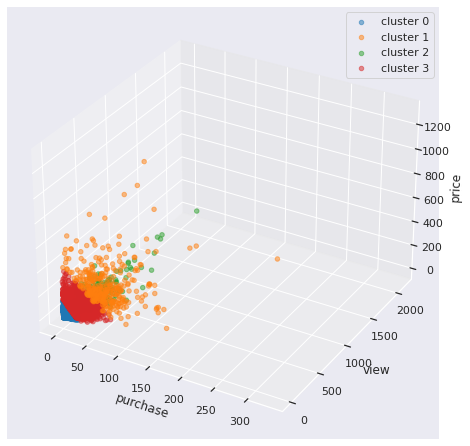

In [30]:
k_mean_cluster(behavior_freq_df, 4)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


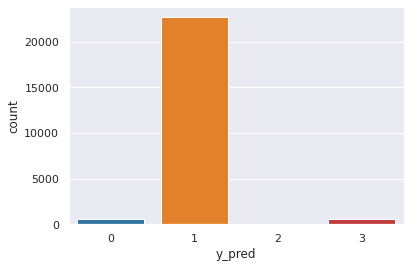

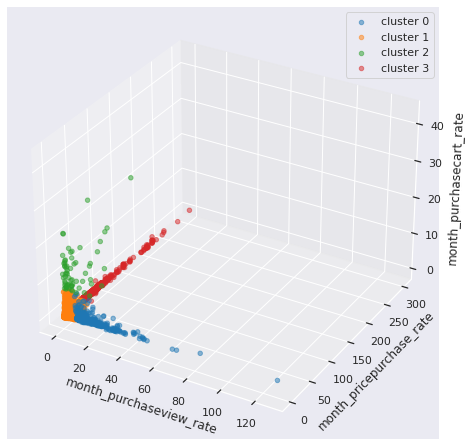

In [31]:
k_mean_cluster(behavior_rate_df, 4)

The following is user's active data features

Text(0, 0.5, 'SE')

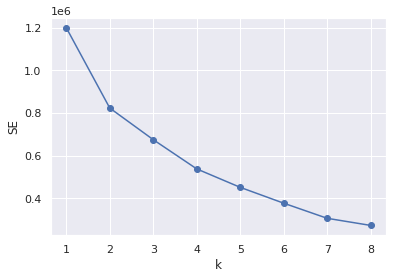

In [32]:
SSE=[]
for i in range(1,9,1):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(X_activeuser)
    SSE.append(kmeans.inertia_)
sns.set()
plt.plot(range(1,9,1),SSE,marker='o')
plt.xlabel('k')
plt.ylabel('SE')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


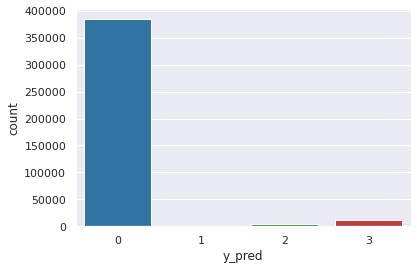

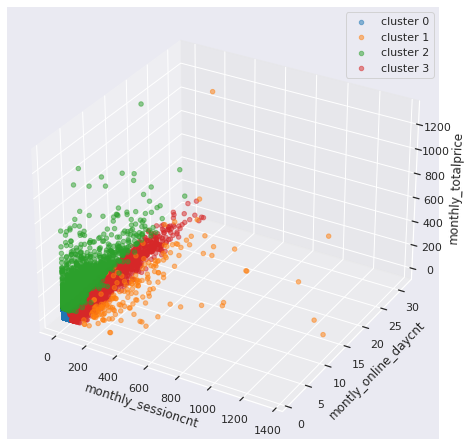

In [33]:
k_mean_cluster(activeuser_df, 4)